In [1]:
import os, sys, urllib, gzip
sys.path.append('/home/rui/pylearn2')
from __future__ import print_function
try:
    import cPickle as pickle
except:
    import pickle
sys.setrecursionlimit(10000)

import numpy as np
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
import pylearn2
from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
from lasagne.regularization import regularize_layer_params, l2, l1
import theano
import theano.tensor as T
import time
import lasagne
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print('Using cuda_convnet (faster)')
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print('Using lasagne.layers (slower)')
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


Using cuda_convnet (faster)


In [2]:
data = np.load('output/data.npz')
data1 = data['arr_0']
data_out1 = data['arr_1']
data2 = data['arr_2']
data_out2 = data['arr_3']
data3 = data['arr_4']
data_out3 = data['arr_5']
data4 = data['arr_6']
data_out4 = data['arr_7']

In [4]:
X = np.concatenate((data1,data2,data3,data4))
X = np.asarray(X, dtype = np.float32)
X = np.reshape(X, (40, 1, 72, 72))

In [5]:
X = X / 255
X_out = X.reshape((X.shape[0], -1))

In [6]:
def get_picture_array(X, rescale=2):
    array = X.reshape(72,72)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

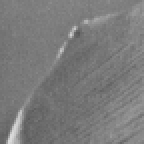

In [7]:
pic_array = get_picture_array(X[2]*255)
image = Image.fromarray(pic_array)
image.save('./output/temp.png', format="PNG")  
IPImage('./output/temp.png')

In [8]:
conv_num_filters = 16
pool_size = 2
encode_size = 128
pad_in = 'valid'    
pad_out = 'full'

In [9]:
def build_cnn(input_var=None):
    
    network = InputLayer(shape=(None,  X.shape[1], X.shape[2], X.shape[3]),input_var=input_var)
    
    network = Conv2DLayerFast(network, name= 'en_conv1_1', num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_in)

    network = Conv2DLayerFast(network, name= 'en_conv1_2', num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)

    network = Conv2DLayerFast(network, name= 'en_conv2_1', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_in)
    
    network = Conv2DLayerFast(network, name= 'en_conv2_2', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)
    
    network = Conv2DLayerFast(network, name= 'en_conv3_1', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=3, pad=pad_in)
    
    network = Conv2DLayerFast(network, name= 'en_conv3_2', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=3, pad=pad_in)
    
    network = ReshapeLayer(network, shape =(([0], -1)))
    
    
    encode_layer = DenseLayer(network, name= 'encode', num_units= encode_size, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify)
   
    network = DenseLayer(encode_layer, num_units= 8*8*2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify)
    
    network = ReshapeLayer(network, shape =(([0], 2*conv_num_filters, 8, 8)))
    
    network = Conv2DLayerFast(network, name= 'de_conv1_1', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=3, pad=pad_out)
    
    network = Conv2DLayerFast(network, name= 'de_conv1_2', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=3, pad=pad_out)
    
    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, name= 'de_conv2_1', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_out)
    
    network = Conv2DLayerFast(network, name= 'de_conv2_2', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_out)

    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, name= 'de_conv3_1', num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_out)

    network = Conv2DLayerSlow(network, name= 'de_conv3_2', num_filters=1, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.sigmoid, filter_size=5, pad=pad_out)
    
    network = ReshapeLayer(network, shape =(([0], -1)))

    return network

In [15]:
# num_epochs = 1000
# input_var = T.tensor4('inputs')
# target_var = T.matrix('targets')
# learnrate=0.01
# # Create neural network model (depending on first command line parameter)
# print("Building model and compiling functions...")
# network = build_cnn(input_var)
# reconstructed = lasagne.layers.get_output(network)
# loss = lasagne.objectives.squared_error(reconstructed, target_var)
# loss = loss.mean()
# params = lasagne.layers.get_all_params(network, trainable=True)
# #updates = lasagne.updates.nesterov_momentum(
# #    loss, params, learning_rate=learnrate, momentum=0.975)
# updates = lasagne.updates.rmsprop(loss, params, learning_rate=learnrate)
# train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
# best_err = 0.03
# print("Starting training...")
# for epoch in range(num_epochs):
#     start_time = time.time()
#     train_err = train_fn(X, X_out)
#         # Then we print the results for this epoch:
#     print("Epoch {} of {} took {:.3f}s".format(
#         epoch + 1, num_epochs, time.time() - start_time))
#     print(train_err)
#     print("training loss:\t\t{:.6f}".format(float(train_err)))
# #     if train_err < best_err:
# #         best_err = train_err
# #         np.savez('./output/autoencoder.npz', *lasagne.layers.get_all_param_values(network))

Building model and compiling functions...
Starting training...
Epoch 1 of 1000 took 0.351s
0.033809512853622437
training loss:		0.033810
Epoch 2 of 1000 took 0.333s
0.034987714141607285
training loss:		0.034988
Epoch 3 of 1000 took 0.332s
0.03369183838367462
training loss:		0.033692
Epoch 4 of 1000 took 0.333s
0.03326476365327835
training loss:		0.033265
Epoch 5 of 1000 took 0.332s
0.03316105902194977
training loss:		0.033161
Epoch 6 of 1000 took 0.333s
0.03310044854879379
training loss:		0.033100
Epoch 7 of 1000 took 0.333s
0.03303876519203186
training loss:		0.033039
Epoch 8 of 1000 took 0.333s
0.03297038748860359
training loss:		0.032970
Epoch 9 of 1000 took 0.333s
0.032889533787965775
training loss:		0.032890
Epoch 10 of 1000 took 0.333s
0.03281131014227867
training loss:		0.032811
Epoch 11 of 1000 took 0.332s
0.033024948090314865
training loss:		0.033025
Epoch 12 of 1000 took 0.333s
0.0395546592772007
training loss:		0.039555
Epoch 13 of 1000 took 0.333s
0.033260904252529144
train

In [10]:
num_epochs = 2000
input_var = T.tensor4('inputs')
target_var = T.matrix('targets')
learnrate=0.005
# Create neural network model (depending on first command line parameter)
print("Building model and compiling functions...")
network = build_cnn(input_var)
reconstructed = lasagne.layers.get_output(network)
loss = lasagne.objectives.squared_error(reconstructed, target_var)
loss = loss.mean()
params = lasagne.layers.get_all_params(network, trainable=True)

with np.load('./output/autoencoder.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)

Building model and compiling functions...


In [13]:
# num_epochs = 500
# updates = lasagne.updates.nesterov_momentum(
#     loss, params, learning_rate=0.0005, momentum=0.975)
# # updates = lasagne.updates.rmsprop(
# #     loss, params[10:12], learning_rate=0.01)
# train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
# print("Starting training...")
# best_err = 0.02
# for epoch in range(num_epochs):
#     start_time = time.time()
#     train_err = train_fn(X, X_out)
#         # Then we print the results for this epoch:
#     print("Epoch {} of {} took {:.3f}s".format(
#         epoch + 1, num_epochs, time.time() - start_time))
#     print(train_err)
#     print("training loss:\t\t{:.6f}".format(float(train_err)))
#     if train_err < best_err:
#         best_err = train_err
#         #np.savez('./output/autoencoder.npz', *lasagne.layers.get_all_param_values(network))

Starting training...
Epoch 1 of 500 took 0.361s
0.0014875360066071153
training loss:		0.001488
Epoch 2 of 500 took 0.334s
0.001248935703188181
training loss:		0.001249
Epoch 3 of 500 took 0.332s
0.001231659553013742
training loss:		0.001232
Epoch 4 of 500 took 0.332s
0.0012827329337596893
training loss:		0.001283
Epoch 5 of 500 took 0.332s
0.0012903702445328236
training loss:		0.001290
Epoch 6 of 500 took 0.332s
0.0012558357557281852
training loss:		0.001256
Epoch 7 of 500 took 0.332s
0.0012255150359123945
training loss:		0.001226
Epoch 8 of 500 took 0.332s
0.001219461322762072
training loss:		0.001219
Epoch 9 of 500 took 0.354s
0.0012250897707417607
training loss:		0.001225
Epoch 10 of 500 took 0.357s
0.0012269688304513693
training loss:		0.001227
Epoch 11 of 500 took 0.338s
0.0012231176951900125
training loss:		0.001223
Epoch 12 of 500 took 0.365s
0.0012190439738333225
training loss:		0.001219
Epoch 13 of 500 took 0.333s
0.0012177638709545135
training loss:		0.001218
Epoch 14 of 500 

In [11]:
output_func = theano.function([input_var], [lasagne.layers.get_output(network)])
data_pred = np.zeros((40,72*72))
data_pred = output_func(X)[0]

In [12]:
data_pred.shape

(40, 5184)

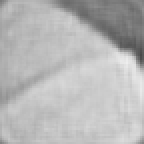

In [13]:
pic_array = get_picture_array(data_pred[5]*255)
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

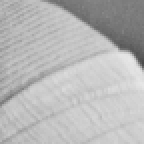

In [14]:
pic_array = get_picture_array(data1[5])
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

In [31]:
cnn_layers = lasagne.layers.get_all_layers(network)
cnn_params = lasagne.layers.get_all_params(network, trainable=True)
all_param_value = lasagne.layers.get_all_param_values(network)

In [16]:
[layer.name for layer in cnn_layers]

[None,
 'en_conv1_1',
 'en_conv1_2',
 None,
 'en_conv2_1',
 'en_conv2_2',
 None,
 'en_conv3_1',
 'en_conv3_2',
 None,
 'encode',
 None,
 None,
 'de_conv1_1',
 'de_conv1_2',
 None,
 'de_conv2_1',
 'de_conv2_2',
 None,
 'de_conv3_1',
 'de_conv3_2',
 None]

In [17]:
cnn_params

[en_conv1_1.W,
 en_conv1_1.b,
 en_conv1_2.W,
 en_conv1_2.b,
 en_conv2_1.W,
 en_conv2_1.b,
 en_conv2_2.W,
 en_conv2_2.b,
 en_conv3_1.W,
 en_conv3_1.b,
 en_conv3_2.W,
 en_conv3_2.b,
 encode.W,
 encode.b,
 W,
 b,
 de_conv1_1.W,
 de_conv1_1.b,
 de_conv1_2.W,
 de_conv1_2.b,
 de_conv2_1.W,
 de_conv2_1.b,
 de_conv2_2.W,
 de_conv2_2.b,
 de_conv3_1.W,
 de_conv3_1.b,
 de_conv3_2.W,
 de_conv3_2.b]

In [22]:
len(all_param_value)

28

In [28]:
def build_ARE(input_var=None):
    
    network = InputLayer(shape=(None,  X.shape[1], X.shape[2], X.shape[3]),input_var=input_var)
    
    network = Conv2DLayerFast(network, name= 'en_conv1_1', num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_in)

    network = Conv2DLayerFast(network, name= 'en_conv1_2', num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)

    network = Conv2DLayerFast(network, name= 'en_conv2_1', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_in)
    
    network = Conv2DLayerFast(network, name= 'en_conv2_2', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)
    
    network = Conv2DLayerFast(network, name= 'en_conv3_1', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=3, pad=pad_in)
    
    network = Conv2DLayerFast(network, name= 'en_conv3_2', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=3, pad=pad_in)
    
    network = ReshapeLayer(network, shape =(([0], -1)))
    
    
    encode_layer = DenseLayer(network, name= 'encode', num_units= encode_size, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify)
    
    action_layer = DenseLayer(encode_layer, name= 'action', num_units= encode_size, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify)
   
    network = DenseLayer(action_layer, num_units= 8*8*2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify)
    
    network = ReshapeLayer(network, shape =(([0], 2*conv_num_filters, 8, 8)))
    
    network = Conv2DLayerFast(network, name= 'de_conv1_1', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=3, pad=pad_out)
    
    network = Conv2DLayerFast(network, name= 'de_conv1_2', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=3, pad=pad_out)
    
    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, name= 'de_conv2_1', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_out)
    
    network = Conv2DLayerFast(network, name= 'de_conv2_2', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_out)

    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, name= 'de_conv3_1', num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_out)

    network = Conv2DLayerSlow(network, name= 'de_conv3_2', num_filters=1, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.sigmoid, filter_size=5, pad=pad_out)
    
    network = ReshapeLayer(network, shape =(([0], -1)))

    return network

In [32]:
input_var = T.tensor4('inputs')
target_var = T.matrix('targets')
action1_w = np.eye(encode_size, dtype = np.float32)
action1_b = np.zeros(encode_size, dtype = np.float32)
action2_w = np.eye(encode_size, dtype = np.float32)
action2_b = np.zeros(encode_size, dtype = np.float32)
action3_w = np.eye(encode_size, dtype = np.float32)
action3_b = np.zeros(encode_size, dtype = np.float32)
action4_w = np.eye(encode_size, dtype = np.float32)
action4_b = np.zeros(encode_size, dtype = np.float32)
ARE_network = build_ARE(input_var)
all_param_value.insert(14, action1_w)
all_param_value.insert(15, action1_b)
lasagne.layers.set_all_param_values(ARE_network, all_param_value)

In [33]:
reconstructed = lasagne.layers.get_output(ARE_network)
loss = lasagne.objectives.squared_error(reconstructed, target_var)
loss = loss.mean()
params = lasagne.layers.get_all_params(ARE_network, trainable=True)

In [35]:
params[14:16]

[action.W, action.b]

In [39]:
X1 = X[:9,:,:,:]
X1_out = X_out[1:10,:]
X2 = X[10:19,:,:,:]
X2_out = X_out[11:20,:]
X3 = X[20:29,:,:,:]
X3_out = X_out[21:30,:]
X4 = X[30:39,:,:,:]
X4_out = X_out[31:40,:]

In [ ]:
all_layers = lasagne.layers.get_all_layers(ARE_network)
action_layer = all_layers[11]

In [ ]:
def set_action_layer(action_id):
    if action_id == 1:
        action_layer.W.set_value(action1_w)
        action_layer.b.set_value(action1_b)
        print('set action1 weight')
    elif action_id == 2:
        action_layer.W.set_value(action2_w)
        action_layer.b.set_value(action2_b)
        print('set action2 weight')
    elif action_id == 3:
        action_layer.W.set_value(action3_w)
        action_layer.b.set_value(action3_b)
        print('set action3 weight')
    elif action_id == 4:
        action_layer.W.set_value(action4_w)
        action_layer.b.set_value(action4_b)
        print('set action4 weight')
    else:
        raise Exception('not a valid action')

In [75]:
def get_action_layer(action_id):
    if action_id == 1:
        action1_w = action_layer.W.get_value()
        action1_b = action_layer.b.get_value()
        print('save action1 weight')
    elif action_id == 2:
        action2_w = action_layer.W.get_value()
        action2_b = action_layer.b.get_value()
        print('save action2 weight')
    elif action_id == 3:
        action3_w = action_layer.W.get_value()
        action3_b = action_layer.b.get_value()
        print('save action3 weight')
    elif action_id == 4:
        action4_w = action_layer.W.get_value()
        action4_b = action_layer.b.get_value()
        print('save action4 weight')
    else:
        raise Exception('not a valid action')

In [63]:
action_layer.W.set_value(action1_w)
action_layer.b.set_value(action1_b)

In [65]:
num_epochs = 2000
updates = lasagne.updates.nesterov_momentum(
    loss, params[14:16], learning_rate=0.001, momentum=0.975)
# updates = lasagne.updates.rmsprop(
#     loss, params[14:16], learning_rate=0.001)
# updates = lasagne.updates.sgd(
#     loss, params[14:16], learning_rate=0.01)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
print("Starting training...")
best_err = 0.02
for epoch in range(num_epochs):
    start_time = time.time()
    train_err = train_fn(X1, X1_out)
        # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("training loss:\t\t{:.6f}".format(float(train_err)))
#     if train_err < best_err:
#         best_err = train_err
#         #np.savez('./output/ARE_lena.npz', *lasagne.layers.get_all_param_values(ARE_network))

Starting training...
Epoch 1 of 2000 took 0.097s
training loss:		0.007018
Epoch 2 of 2000 took 0.098s
training loss:		0.007018
Epoch 3 of 2000 took 0.097s
training loss:		0.007018
Epoch 4 of 2000 took 0.090s
training loss:		0.007018
Epoch 5 of 2000 took 0.089s
training loss:		0.007018
Epoch 6 of 2000 took 0.092s
training loss:		0.007017
Epoch 7 of 2000 took 0.088s
training loss:		0.007017
Epoch 8 of 2000 took 0.087s
training loss:		0.007017
Epoch 9 of 2000 took 0.091s
training loss:		0.007017
Epoch 10 of 2000 took 0.088s
training loss:		0.007017
Epoch 11 of 2000 took 0.087s
training loss:		0.007017
Epoch 12 of 2000 took 0.091s
training loss:		0.007017
Epoch 13 of 2000 took 0.089s
training loss:		0.007017
Epoch 14 of 2000 took 0.087s
training loss:		0.007016
Epoch 15 of 2000 took 0.091s
training loss:		0.007016
Epoch 16 of 2000 took 0.088s
training loss:		0.007016
Epoch 17 of 2000 took 0.087s
training loss:		0.007016
Epoch 18 of 2000 took 0.091s
training loss:		0.007016
Epoch 19 of 2000

In [66]:
action1_w = action_layer.W.get_value()
action1_b = action_layer.b.get_value()

In [55]:
action_layer.W.set_value(action2_w)
action_layer.b.set_value(action2_b)

In [58]:
num_epochs = 5000
updates = lasagne.updates.nesterov_momentum(
    loss, params[14:16], learning_rate=0.001, momentum=0.975)
# updates = lasagne.updates.rmsprop(
#     loss, params[14:16], learning_rate=0.001)
# updates = lasagne.updates.sgd(
#     loss, params[14:16], learning_rate=0.01)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
print("Starting training...")
for epoch in range(num_epochs):
    start_time = time.time()
    train_err = train_fn(X2, X2_out)
        # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("training loss:\t\t{:.6f}".format(float(train_err)))

Starting training...
Epoch 1 of 2000 took 0.098s
training loss:		0.004906
Epoch 2 of 2000 took 0.098s
training loss:		0.004906
Epoch 3 of 2000 took 0.093s
training loss:		0.004905
Epoch 4 of 2000 took 0.091s
training loss:		0.004905
Epoch 5 of 2000 took 0.087s
training loss:		0.004905
Epoch 6 of 2000 took 0.090s
training loss:		0.004905
Epoch 7 of 2000 took 0.088s
training loss:		0.004905
Epoch 8 of 2000 took 0.090s
training loss:		0.004905
Epoch 9 of 2000 took 0.092s
training loss:		0.004905
Epoch 10 of 2000 took 0.096s
training loss:		0.004905
Epoch 11 of 2000 took 0.096s
training loss:		0.004905
Epoch 12 of 2000 took 0.095s
training loss:		0.004905
Epoch 13 of 2000 took 0.088s
training loss:		0.004905
Epoch 14 of 2000 took 0.090s
training loss:		0.004905
Epoch 15 of 2000 took 0.093s
training loss:		0.004905
Epoch 16 of 2000 took 0.088s
training loss:		0.004905
Epoch 17 of 2000 took 0.087s
training loss:		0.004905
Epoch 18 of 2000 took 0.092s
training loss:		0.004905
Epoch 19 of 2000

In [62]:
action2_w = action_layer.W.get_value()
action2_b = action_layer.b.get_value()

In [79]:
set_action_layer(3)
num_epochs = 3000
updates = lasagne.updates.nesterov_momentum(
    loss, params[14:16], learning_rate=0.005, momentum=0.975)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
print("Starting training...")
for epoch in range(num_epochs):
    start_time = time.time()
    train_err = train_fn(X3, X3_out)
        # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("training loss:\t\t{:.6f}".format(float(train_err)))

set action3 weight
Starting training...
Epoch 1 of 3000 took 0.097s
training loss:		0.055811
Epoch 2 of 3000 took 0.095s
training loss:		0.055018
Epoch 3 of 3000 took 0.093s
training loss:		0.053730
Epoch 4 of 3000 took 0.088s
training loss:		0.052129
Epoch 5 of 3000 took 0.087s
training loss:		0.050414
Epoch 6 of 3000 took 0.091s
training loss:		0.048758
Epoch 7 of 3000 took 0.088s
training loss:		0.047279
Epoch 8 of 3000 took 0.087s
training loss:		0.045970
Epoch 9 of 3000 took 0.091s
training loss:		0.044929
Epoch 10 of 3000 took 0.087s
training loss:		0.044018
Epoch 11 of 3000 took 0.088s
training loss:		0.043203
Epoch 12 of 3000 took 0.090s
training loss:		0.042506
Epoch 13 of 3000 took 0.087s
training loss:		0.041829
Epoch 14 of 3000 took 0.087s
training loss:		0.041150
Epoch 15 of 3000 took 0.091s
training loss:		0.040439
Epoch 16 of 3000 took 0.087s
training loss:		0.039703
Epoch 17 of 3000 took 0.088s
training loss:		0.039064
Epoch 18 of 3000 took 0.090s
training loss:		0.0386

In [80]:
action3_w = action_layer.W.get_value()
action3_b = action_layer.b.get_value()

In [81]:
set_action_layer(4)
num_epochs = 3000
updates = lasagne.updates.nesterov_momentum(
    loss, params[14:16], learning_rate=0.005, momentum=0.975)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
print("Starting training...")
for epoch in range(num_epochs):
    start_time = time.time()
    train_err = train_fn(X4, X4_out)
        # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("training loss:\t\t{:.6f}".format(float(train_err)))

set action4 weight
Starting training...
Epoch 1 of 3000 took 0.098s
training loss:		0.040536
Epoch 2 of 3000 took 0.093s
training loss:		0.039933
Epoch 3 of 3000 took 0.094s
training loss:		0.038938
Epoch 4 of 3000 took 0.088s
training loss:		0.037783
Epoch 5 of 3000 took 0.087s
training loss:		0.036570
Epoch 6 of 3000 took 0.091s
training loss:		0.035359
Epoch 7 of 3000 took 0.087s
training loss:		0.034143
Epoch 8 of 3000 took 0.087s
training loss:		0.033003
Epoch 9 of 3000 took 0.091s
training loss:		0.031957
Epoch 10 of 3000 took 0.087s
training loss:		0.031038
Epoch 11 of 3000 took 0.088s
training loss:		0.030281
Epoch 12 of 3000 took 0.091s
training loss:		0.029640
Epoch 13 of 3000 took 0.087s
training loss:		0.029091
Epoch 14 of 3000 took 0.088s
training loss:		0.028668
Epoch 15 of 3000 took 0.092s
training loss:		0.028329
Epoch 16 of 3000 took 0.099s
training loss:		0.028014
Epoch 17 of 3000 took 0.103s
training loss:		0.027719
Epoch 18 of 3000 took 0.098s
training loss:		0.0273

In [82]:
get_action_layer(4)

save action4 weight


In [84]:
# np.savez('output/action_weight.npz', action1_w, action1_b, action2_w, action2_b,action3_w, action3_b,action4_w, action4_b)

In [85]:
temp = np.load('output/action_weight.npz')
action1_w = temp['arr_0']
action1_b = temp['arr_1']
action2_w = temp['arr_2']
action2_b = temp['arr_3']
action3_w = temp['arr_4']
action3_b = temp['arr_5']
action4_w = temp['arr_6']
action4_b = temp['arr_7']

In [95]:
num_epochs = 1000
updates = lasagne.updates.nesterov_momentum(
    loss, params, learning_rate=0.001, momentum=0.975)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
print("Starting training...")
best_err = 0.00231
for epoch in range(num_epochs):
    start_time = time.time()
    set_action_layer(1)
    train_err1 = train_fn(X1, X1_out)
    get_action_layer(1)
    set_action_layer(2)
    train_err2 = train_fn(X2, X2_out)
    get_action_layer(2)
    set_action_layer(3)
    train_err3 = train_fn(X3, X3_out)
    get_action_layer(3)
    set_action_layer(4)
    train_err4 = train_fn(X4, X4_out)
    get_action_layer(4)
    train_err = np.mean([float(train_err1), float(train_err2), float(train_err3), float(train_err4)])
        # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("training loss:\t\t{:.6f}".format(float(train_err)))
    if train_err < best_err:
        best_err = train_err
        np.savez('./output/ARE_lena.npz', *lasagne.layers.get_all_param_values(ARE_network))

Starting training...
set action1 weight
save action1 weight
set action2 weight
save action2 weight
set action3 weight
save action3 weight
set action4 weight
save action4 weight
Epoch 1 of 1000 took 0.701s
training loss:		0.002291
set action1 weight
save action1 weight
set action2 weight
save action2 weight
set action3 weight
save action3 weight
set action4 weight
save action4 weight
Epoch 2 of 1000 took 0.650s
training loss:		0.002288
set action1 weight
save action1 weight
set action2 weight
save action2 weight
set action3 weight
save action3 weight
set action4 weight
save action4 weight
Epoch 3 of 1000 took 0.642s
training loss:		0.002285
set action1 weight
save action1 weight
set action2 weight
save action2 weight
set action3 weight
save action3 weight
set action4 weight
save action4 weight
Epoch 4 of 1000 took 0.646s
training loss:		0.002291
set action1 weight
save action1 weight
set action2 weight
save action2 weight
set action3 weight
save action3 weight
set action4 weight
save ac

In [125]:
num_epochs = 2000
updates = lasagne.updates.nesterov_momentum(
    loss, params, learning_rate=0.0005, momentum=0.95)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
print("Starting training...")
best_err = 0.0020
for epoch in range(num_epochs):
    start_time = time.time()
    set_action_layer(1)
    train_err1 = train_fn(X1, X1_out)
    get_action_layer(1)
    set_action_layer(2)
    train_err2 = train_fn(X2, X2_out)
    get_action_layer(2)
    set_action_layer(3)
    train_err3 = train_fn(X3, X3_out)
    get_action_layer(3)
    set_action_layer(4)
    train_err4 = train_fn(X4, X4_out)
    get_action_layer(4)
    train_err = np.mean([float(train_err1), float(train_err2), float(train_err3), float(train_err4)])
        # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("training loss:\t\t{:.6f}".format(float(train_err)))
    if train_err < best_err:
        best_err = train_err
        np.savez('./output/ARE_lena.npz', *lasagne.layers.get_all_param_values(ARE_network))

Starting training...
set action1 weight
save action1 weight
set action2 weight
save action2 weight
set action3 weight
save action3 weight
set action4 weight
save action4 weight
Epoch 1 of 2000 took 0.670s
training loss:		0.001900
set action1 weight
save action1 weight
set action2 weight
save action2 weight
set action3 weight
save action3 weight
set action4 weight
save action4 weight
Epoch 2 of 2000 took 0.647s
training loss:		0.001899
set action1 weight
save action1 weight
set action2 weight
save action2 weight
set action3 weight
save action3 weight
set action4 weight
save action4 weight
Epoch 3 of 2000 took 0.647s
training loss:		0.001898
set action1 weight
save action1 weight
set action2 weight
save action2 weight
set action3 weight
save action3 weight
set action4 weight
save action4 weight
Epoch 4 of 2000 took 0.647s
training loss:		0.001898
set action1 weight
save action1 weight
set action2 weight
save action2 weight
set action3 weight
save action3 weight
set action4 weight
save ac

In [126]:
np.savez('output/action_weight_after_combined_trainning.npz', action1_w, action1_b, action2_w, action2_b,action3_w, action3_b,action4_w, action4_b)

In [127]:
set_action_layer(1)
output_func = theano.function([input_var], [lasagne.layers.get_output(ARE_network)])
data_pred = output_func(X1)[0]

set action1 weight


In [128]:
data_pred.shape

(9, 5184)

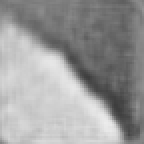

In [137]:
pic_id = 5
pic_array = get_picture_array(data_pred[pic_id]*255)
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

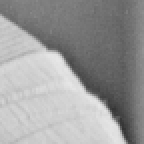

In [138]:
pic_array = get_picture_array(data1[pic_id+1])
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

In [139]:
all_layers = lasagne.layers.get_all_layers(ARE_network)
encode_layer = all_layers[10]

In [140]:
output_func = theano.function([input_var], [lasagne.layers.get_output(encode_layer)])
X_encode = output_func(X)[0]

In [141]:
X_encode.shape

(40, 128)

In [142]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pcomp = pca.fit_transform(X_encode)

In [143]:
X_pcomp

array([[-475.94717407,  -75.03575134],
       [-270.03729248,  -36.01636505],
       [-233.54974365, -174.37800598],
       [ -77.8710022 ,   31.27505493],
       [ 252.57209778,  340.60174561],
       [ 723.57275391,   45.53860474],
       [ 590.90405273, -757.10449219],
       [-126.84722137,  292.81726074],
       [-114.53707123, -166.68637085],
       [ 100.85058594, -266.55255127],
       [-599.17919922, -768.96990967],
       [-943.92919922,   12.95314884],
       [-377.10543823,  812.69891357],
       [  19.36332703,  389.95669556],
       [ 234.88725281,  -75.69705963],
       [ 188.82739258, -155.60050964],
       [ 114.02610016,  -48.56303024],
       [ 185.2441864 ,  396.56246948],
       [ 236.05163574,  652.92547607],
       [ 359.61355591,  770.69506836],
       [ 499.81863403, -676.5067749 ],
       [ -27.41634941,   -5.40200424],
       [ 477.44711304, -479.97567749],
       [ 630.75018311,  166.64880371],
       [ 151.44113159,  148.11404419],
       [   3.78328991,  -

In [145]:
for row in X_pcomp:
    print(tuple(row))

(-475.94717, -75.035751)
(-270.03729, -36.016365)
(-233.54974, -174.37801)
(-77.871002, 31.275055)
(252.5721, 340.60175)
(723.57275, 45.538605)
(590.90405, -757.10449)
(-126.84722, 292.81726)
(-114.53707, -166.68637)
(100.85059, -266.55255)
(-599.1792, -768.96991)
(-943.9292, 12.953149)
(-377.10544, 812.69891)
(19.363327, 389.9567)
(234.88725, -75.69706)
(188.82739, -155.60051)
(114.0261, -48.56303)
(185.24419, 396.56247)
(236.05164, 652.92548)
(359.61356, 770.69507)
(499.81863, -676.50677)
(-27.416349, -5.4020042)
(477.44711, -479.97568)
(630.75018, 166.6488)
(151.44113, 148.11404)
(3.7832899, -89.457161)
(-410.28006, 163.45387)
(-775.6767, -329.93942)
(-506.34329, -164.36566)
(-896.44702, -156.15422)
(3.7832899, -89.457161)
(-66.514252, 69.454758)
(-120.37718, 123.40461)
(44.326717, -180.04616)
(262.043, -196.46411)
(25.340231, 136.56982)
(333.39209, -59.815281)
(-269.17422, 559.0116)
(248.7948, -166.08725)
(604.39874, 5.5915389)


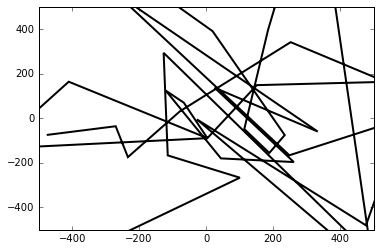

In [149]:
from matplotlib.path import Path
import matplotlib.patches as patches

verts = [tuple(row) for row in X_pcomp]
codes = [Path.MOVETO]
for i in range(39):
    codes.append(Path.LINETO)

path = Path(verts, codes)

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax.add_patch(patch)
ax.set_xlim(-500,500)
ax.set_ylim(-500,500)

plt.show()

In [148]:
verts

[(-475.94717, -75.035751),
 (-270.03729, -36.016365),
 (-233.54974, -174.37801),
 (-77.871002, 31.275055),
 (252.5721, 340.60175),
 (723.57275, 45.538605),
 (590.90405, -757.10449),
 (-126.84722, 292.81726),
 (-114.53707, -166.68637),
 (100.85059, -266.55255),
 (-599.1792, -768.96991),
 (-943.9292, 12.953149),
 (-377.10544, 812.69891),
 (19.363327, 389.9567),
 (234.88725, -75.69706),
 (188.82739, -155.60051),
 (114.0261, -48.56303),
 (185.24419, 396.56247),
 (236.05164, 652.92548),
 (359.61356, 770.69507),
 (499.81863, -676.50677),
 (-27.416349, -5.4020042),
 (477.44711, -479.97568),
 (630.75018, 166.6488),
 (151.44113, 148.11404),
 (3.7832899, -89.457161),
 (-410.28006, 163.45387),
 (-775.6767, -329.93942),
 (-506.34329, -164.36566),
 (-896.44702, -156.15422),
 (3.7832899, -89.457161),
 (-66.514252, 69.454758),
 (-120.37718, 123.40461),
 (44.326717, -180.04616),
 (262.043, -196.46411),
 (25.340231, 136.56982),
 (333.39209, -59.815281),
 (-269.17422, 559.0116),
 (248.7948, -166.08725),